###  Homework 1.5: All Possible Regressions

This is a quick assignment, not an entire project.  I would expect it to only take a couple of hours to complete. The start of this notebook develops the example.  You will then parallelize the exammple using `joblib`. 

Run this on a machine that has at least 4 cores. Google Colab is not adequate. Fill out the requested cells toward the bottom of the notebook.

**Due date**: October 1, 2021, 5:00 pm EDT.

**Instructions for Submission**: TODO

#### Example code

This is a Python reimplementation of the Section 3.4. in _Matloff_, Parallel Computing for Data Science. It is based on data from https://www.kaggle.com/divan0/multiple-linear-regression. The notebook asks the question what combination of variables best predict the price of a house.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

#importing dataset using panda
dataset = pd.read_csv('../data/kc_house_data.csv')
#to see what my dataset is comprised of
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [2]:
#dropping the id and date column
dataset = dataset.drop(['id','date'], axis = 1)

# clean out NaN and inf values
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

Let's first do a simple regression. How does square footage predict price? 

In [4]:
from sklearn.linear_model import LinearRegression

X = np.array(dataset.sqft_living)
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],1))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.4928817196006995


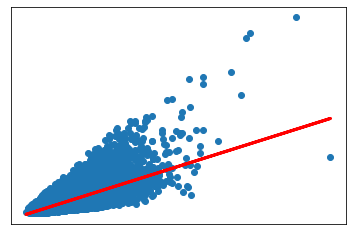

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# scatter data
plt.plot(X,Y,'o')
# best fit line
y_pred = model.intercept_ + model.coef_ * X
plt.plot(X, y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

We see that there is a strong correlation between square footage and house price.  The coefficient of determination measures the strength of the correlation and varies between 0 (no correlation) and 1.0 (perfectly correlated).

### Multiple Linear Regression

Adding more variables often improves the score.

In [6]:
X = np.array(dataset[['sqft_living','condition','yr_built']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.5249639858277426


but some variables are confounding

In [7]:
X = np.array(dataset[['zipcode','floors','waterfront']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.13588749977708692


This leads to a first parallel program.  What are the right set of variables? A brute force approach called _All Possible Regressions_ examines all combinations. So, let's build a big matrix that and we will regress on subsets.  We will look at all combinations of 1, 2, or 3 variables.

In [8]:
from itertools import combinations, chain

Y = np.array(dataset.price)
X = np.array(dataset.drop(['price'], axis=1))

## Let's choose all combinations of 1, 2, and 3 columns.
col_idxs = np.array(range(X.shape[1]))
combos = list(chain(combinations(col_idxs, 1), combinations(col_idxs, 2), combinations(col_idxs, 3)))

In [11]:
model = LinearRegression()

# do in a for loop (dumbest way)
r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo
    
print(r_sq_best, combo_best)

0.6095149101819037 (2, 6, 14)


The outcome is kind of crazy. The fields are `sqft-living`, `view`, and `latitude`. Latitude is probably a somewhat accurate proxy for wealth in this area, e.g. N of town richer than south of town. But, this is the kind of outcome that would not translate to other regions, i.e. is likely specific to this data.  _Neat_.

Back to performance.

In [16]:
%%timeit
model = LinearRegression()

r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo

1.07 s ± 27.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's see if flattening the loop matters. Replace for loop with a list comprehension of all combination of variables.

In [19]:
def r_sq_regression (combo):
    Xp = X[:,combo]
    model = LinearRegression()
    model = model.fit(Xp,Y)
    return model.score(Xp,Y)

In [21]:
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])
print(r_sq_arr[r_sq_idx])

[(2, 6, 14) 0.6095149101819037]


In [23]:
%%timeit
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)
r_sq_idx = np.argmax(r_sq_arr[:,1])

1.06 s ± 9.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It didn't seem to help. But, this is a step toward parallelization.

### Exercise (This is the assignment)

1. Use `joblib.Parallel` and `joblib.delayed` to parallelize the computation of the calls to `r_sq_regression`. 
    1. In one cell, print the answer to verify that your parallel program is correct.
    2. In another cell time the computation. What is the speedup at `n_jobs=4`?

In [4]:
# TODO code for 1A

In [ ]:
%%timeit 
# TODO code for 1B 

**TODO Answer for 1B**

2. Use the batch size parameter to vary the number of jobs in each batch from 1,2,...128 @ n_jobs=4. 
   1. Plot your results (use %timeit -o to capture output)
   2. Model the problem as having two performance components: a fixed startup cost per batch ($C_B$) and perfect parallelism.  Estimate the batch startup cost (give a range). Is this a good model?  Explain.

In [3]:
# code for 2A

In [ ]:
%matplotlib inline

# TODO plot for 2A

In [ ]:
# code for 2B

**TODO Answer for 2B**

3) Run the job with `prefer='threads'` and `prefer='processes'`. Given that `LinearRegression.fit()` consumes almost all the runtime, what can you conclude about the implementation of`LinearRegression.fit()`?  

_Note_: you can verify this conclusion by calling `LinearRegression.fit()` directly, rather than call the wrapper functions `r_sq_regression`.

In [ ]:
# Code for 3

**TTODO Answer to 3**